## Model Training NB: 
This notebook is used to create a data loader for the images along with creating a CNN model to train specifically to detect clear and blurry images from the dataset. 
Here are the steps that I did in this notebook
- Create Data Loader for train, valid and test. There are more blurry images than clear one so I sampled extra clear images (with different image transformation through reversing the image). This way, the dataset for train and valid would be balanced 
- Create a base model: with a simple CNN architecture, I want to see how well the model performs 
- Train model with CV2 model or CLIP-IQA
    - Model Evaluation should include: accuracy score, and confusion matrix 

**Notes**: So far, for this notebook, I have finished the data loader, and create a base model. There are still a lot of work left for CV2 and CLIP-IQA as I need need to read their codes and documentations to figure out how can I change the code such that it can be applied for this problem

### Import data and create a data loader 
The image for this is resize to 224x224 as it is a common dimension for most models. The resize is to scale the image down. Another resize approach that I want to test is keeping the aspect ratio of the image while scaling down and then pad the images so it would fit in the 224x224 dimensions


In [1]:
import os 
import pandas as pd 
import numpy as np
import torch 
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from collections import Counter

import cv2
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Data files and folders
current_wd = os.getcwd()
data_file = f'{current_wd}/data'

blurry_folder = os.path.join(data_file, 'blurry')
clear_folder = os.path.join(data_file, 'clear')
test_folder = os.path.join(data_file, 'to-be-classified')

In [3]:
# Create metadata for clear and blurry images
def create_metadata(clear_folder, blurry_folder):
    metadata = []
    for img_name in os.listdir(clear_folder):
        metadata.append({'image_path': os.path.join(clear_folder, img_name), 'label': 1})
    for img_name in os.listdir(blurry_folder):
        metadata.append({'image_path': os.path.join(blurry_folder, img_name), 'label': 0})
    return pd.DataFrame(metadata)

images_path_w_metadata = create_metadata(clear_folder, blurry_folder)
images_path_w_metadata.head()

,image_path,label
0,c:\Users\tata\Documents\Vanderbilt_research_pr...,1
1,c:\Users\tata\Documents\Vanderbilt_research_pr...,1
2,c:\Users\tata\Documents\Vanderbilt_research_pr...,1
3,c:\Users\tata\Documents\Vanderbilt_research_pr...,1
4,c:\Users\tata\Documents\Vanderbilt_research_pr...,1


In [4]:
# Split clear and blurry images into train and validation sets
def split_data(metadata, train_size=200, valid_size=40):
    clear_images = metadata[metadata['label'] == 1]
    blurry_images = metadata[metadata['label'] == 0]

    clear_train, clear_valid = train_test_split(clear_images, random_state=42)
    blurry_train, blurry_valid = train_test_split(blurry_images, random_state=42)

    train_metadata = pd.concat([clear_train, blurry_train]).sample(frac=1).reset_index(drop=True)
    valid_metadata = pd.concat([clear_valid, blurry_valid]).sample(frac=1).reset_index(drop=True)

    return train_metadata, valid_metadata

train_metadata, valid_metadata = split_data(images_path_w_metadata)

In [5]:
clear_train = train_metadata[train_metadata['label'] == 1]
blurry_train = train_metadata[train_metadata['label'] == 0]
clear_valid = valid_metadata[valid_metadata['label'] == 1]
blurry_valid = valid_metadata[valid_metadata['label'] == 0]
print("clear train: ", len(clear_train))
print("blurry train: ", len(blurry_train))
print("clear valid: ", len(clear_valid))
print("blurry valid: ", len(blurry_valid))


clear train:  64
blurry train:  123
clear valid:  22
blurry valid:  42


In [6]:
 # Balance datasets by augmenting images
def augment_data(metadata, target_size):
    current_size = len(metadata)
    if current_size >= target_size:
        return metadata

    augment_needed = target_size - current_size
    augmented_metadata = metadata.sample(augment_needed, replace=True, random_state=42)
    augment_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10)
    ])
    augmented_images = []
    for idx, row in augmented_metadata.iterrows():
        image = Image.open(row['image_path']).convert('RGB')
        image = augment_transform(image)
        # Save augmented images temporarily in a list with their label
        augmented_images.append({'image': image, 'label': row['label']})
    
    augmented_df = pd.DataFrame(augmented_images)
    return pd.concat([metadata, augmented_df]).sample(frac=1).reset_index(drop=True)


train_metadata = pd.concat([
    augment_data(clear_train, len(blurry_train)),
    augment_data(blurry_train, len(blurry_train))
]).sample(frac=1).reset_index(drop=True)

valid_metadata = pd.concat([
    augment_data(clear_valid, len(blurry_valid)),
    augment_data(blurry_valid, len(blurry_valid))
]).sample(frac=1).reset_index(drop=True)

In [7]:

# Custom Dataset class with OpenCV conversion
class ImageDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        if 'image' in self.metadata.iloc[idx] and isinstance(self.metadata.iloc[idx]['image'], Image.Image):
            image = self.metadata.iloc[idx]['image']
        else:
            img_path = self.metadata.iloc[idx]['image_path']
            image = Image.open(img_path).convert('RGB')
        
        label = self.metadata.iloc[idx]['label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create DataLoaders
def create_dataloader(metadata, transform, batch_size=32, shuffle=True):
    dataset = ImageDataset(metadata, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader = create_dataloader(train_metadata, transform)
valid_loader = create_dataloader(valid_metadata, transform)

test_metadata = pd.DataFrame([{'image_path': os.path.join(test_folder, img_name)} for img_name in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, img_name))])
test_loader = create_dataloader(test_metadata, transform, shuffle=False)

In [8]:

# Count labels from a DataLoader
def count_labels_from_dataloader(dataloader):
    label_counter = Counter()
    for _, labels in dataloader:
        label_counter.update(labels.numpy())
    return label_counter

train_label_counts = count_labels_from_dataloader(train_loader)
valid_label_counts = count_labels_from_dataloader(valid_loader)

print("Label counts in the training set:", train_label_counts)
print("Label counts in the validation set:", valid_label_counts)


Label counts in the training set: Counter({1: 123, 0: 123})
Label counts in the validation set: Counter({0: 42, 1: 42})


## Train the model
### Simple CNN: 

The `SimpleBlurDetectionModel` class is designed for detecting blur in images using a neural network. It provides the following functionalities:

- **Initialization**:
  - Configures the model with specified neurons, data loaders, learning rate, maximum iterations, and early stopping patience.
  - Utilizes GPU if available.

- **Training**:
  - Trains the neural network using the provided training data loader.
  - Implements early stopping based on validation loss to prevent overfitting.
  - Logs training and validation loss for each epoch.

- **Validation**:
  - Evaluates the model's performance on the validation set.
  - Computes and returns the average validation loss.

- **Evaluation**:
  - Loads the best model parameters saved during training.
  - Calculates and prints the accuracy of the model on the validation set.
  - Generates and displays a confusion matrix for detailed performance analysis.

- **Model Management**:
  - Provides methods to save and load model weights for future use.

This class ensures a streamlined workflow for training, validating, and evaluating a blur detection neural network, making it a valuable tool for image quality assessment.


In [10]:
class SimpleBlurDetectionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleBlurDetectionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


In [11]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path=f'{os.getcwd()}/checkpoint.pth'):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        self.best_loss = val_loss
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')


In [14]:
class SimpleBlurDetectionModel:
    def __init__(self, neurons, train_loader, valid_loader, learning_rate=0.001, max_iter=50, patience=10):
        self.neurons = neurons
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.patience = patience
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = SimpleBlurDetectionNN(neurons[0], neurons[1], neurons[2]).to(self.device)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.early_stopping = EarlyStopping(patience=self.patience, verbose=True, path=f'{os.getcwd()}/best_model.pth')

    def train(self):
        self.model.train()
        for epoch in range(self.max_iter):
            epoch_loss = 0
            self.model.train()  # Set the model to training mode
            for images, labels in self.train_loader:
                images = images.view(images.size(0), -1).to(self.device)
                labels = labels.view(-1, 1).float().to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            valid_loss = self.validate()
            print(f'Epoch [{epoch+1}/{self.max_iter}], Train Loss: {epoch_loss/len(self.train_loader):.4f}, Validation Loss: {valid_loss:.4f}')

            self.early_stopping(valid_loss, self.model)

            if self.early_stopping.early_stop:
                print("Early stopping")
                break

    def validate(self):
        self.model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, labels in self.valid_loader:
                images = images.view(images.size(0), -1).to(self.device)
                labels = labels.view(-1, 1).float().to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                valid_loss += loss.item()

        return valid_loss / len(self.valid_loader)

    def evaluate(self):
        self.model.load_state_dict(torch.load('best_model.pth'))  # Load the best model
        self.model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in self.valid_loader:
                images = images.view(images.size(0), -1).to(self.device)
                labels = labels.view(-1, 1).float().to(self.device)
                outputs = self.model(images)
                predicted = (outputs > 0.5).float()
                print("predicted: ", predicted)
                print("labels: ", labels)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        print(f'Accuracy of the model on the validation images: {accuracy:.2f}%')

        # Confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))


Epoch [1/50], Train Loss: 0.7262, Validation Loss: 0.7660
Validation loss decreased (0.765952 --> 0.765952).  Saving model ...
Epoch [2/50], Train Loss: 0.7043, Validation Loss: 0.7534
Validation loss decreased (0.753410 --> 0.753410).  Saving model ...
Epoch [3/50], Train Loss: 0.7014, Validation Loss: 0.7668
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.6990, Validation Loss: 0.7675
EarlyStopping counter: 2 out of 5
Epoch [5/50], Train Loss: 0.7036, Validation Loss: 0.7479
Validation loss decreased (0.747939 --> 0.747939).  Saving model ...
Epoch [6/50], Train Loss: 0.6965, Validation Loss: 0.7227
Validation loss decreased (0.722748 --> 0.722748).  Saving model ...
Epoch [7/50], Train Loss: 0.6946, Validation Loss: 0.7021
Validation loss decreased (0.702143 --> 0.702143).  Saving model ...
Epoch [8/50], Train Loss: 0.6918, Validation Loss: 0.7351
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.6860, Validation Loss: 0.7440
EarlyStopping counter: 2 out of

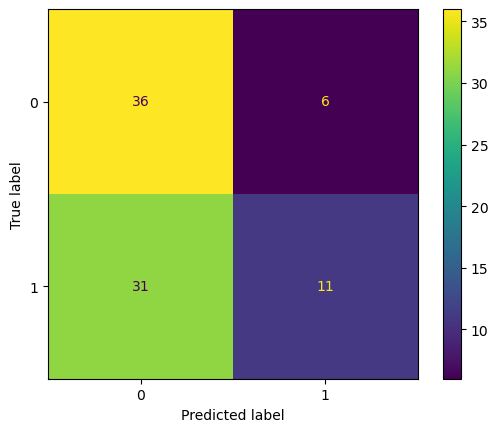

In [16]:
# Assuming train_loader and valid_loader are already defined and available
neurons = (3 * 224 * 224, 128, 1)  # Assuming input images are 224x224 with 3 channels
model = SimpleBlurDetectionModel(neurons, train_loader, valid_loader, max_iter=50, patience=5)

# Train the model with early stopping
model.train()


# Evaluate the model
model.evaluate()

# Save the final model
model.save_model('blur_detection_model.pth')

## Comments: 
The model shows some capability in classifying images, its performance is limited by a significant number of false negatives and a relatively low accuracy. I want to compare this with other models that specifically used to train for bluriness detection. 